In [49]:
import os 
import tarfile
import math
import random 
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets.utils import download_url 
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision import models
from tqdm.notebook import tqdm

In [50]:
print(torch.__version__)

2.8.0+cu126


In [51]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

In [52]:
DATASET_PATH = '/kaggle/working/oxford-iiit-pet.tgz'

In [53]:
with tarfile.open(DATASET_PATH, 'r:gz') as tar:
    tar.extractall(path = '/kaggle/working/data')

/tmp/ipykernel_55/3828624988.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path = '/kaggle/working/data')


7393 total images found (length of dataset)


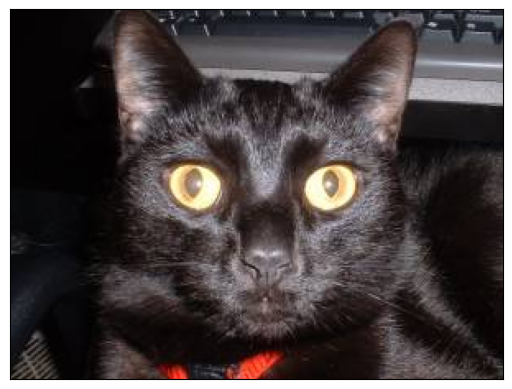

In [54]:
IMAGE_DATA_DIR = '/kaggle/working/data/oxford-iiit-pet/images'
ANNOTATIONS_DATA_DIR = '/kaggle/working/data/oxford-iiit-pet/annotations'


def show_image_from_file(image_directory = IMAGE_DATA_DIR, annot_directory = ANNOTATIONS_DATA_DIR):
    image_files = os.listdir(image_directory)
    print(f'{len(image_files)} total images found (length of dataset)')

    image = Image.open(image_directory + '/' + image_files[random.randint(1, len(image_files) + 1)])
    
    plt.xticks([]); plt.yticks([]);
    plt.imshow(image)
    

show_image_from_file()

In [55]:
print(f'Annotations dir content : {os.listdir(ANNOTATIONS_DATA_DIR)}')
sample = os.listdir(IMAGE_DATA_DIR)[6]
print(sample)

parts = sample.split('_')
print(parts)

n = ''.join(parts[:-1])
n

Annotations dir content : ['test.txt', 'xmls', 'trimaps', 'README', '._trimaps', 'list.txt', 'trainval.txt']
german_shorthaired_183.jpg
['german', 'shorthaired', '183.jpg']


'germanshorthaired'

In [56]:
def parse_breed(fname):
    parts = fname.split('_')
    return ''.join(parts[:-1])

In [57]:
def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

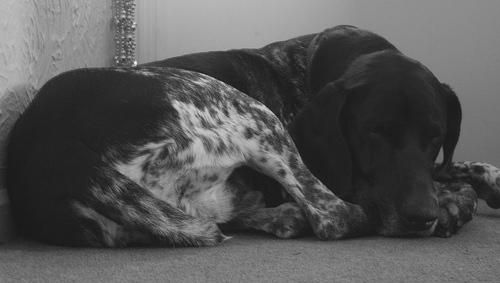

In [58]:
open_image(IMAGE_DATA_DIR + '/' + os.listdir(IMAGE_DATA_DIR)[6])

In [59]:
class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.transform = transform

        # root : IMAGE_DATA_DIR
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in self.files))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(IMAGE_DATA_DIR + '/' + fname))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [60]:
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.299, 0.224, 0.225])

transform_func = T.Compose([
    T.Resize(img_size),
    T.Pad(8, padding_mode = 'reflect'),
    T.RandomCrop(img_size),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)
])

dataset = PetsDataset(root = IMAGE_DATA_DIR, transform = transform_func)
print(f'Dataset length : {len(dataset)}')

Dataset length : 7390


In [61]:
print(dataset.classes)
print(f'Total classes : {len(dataset.classes)}')

dataset.root

['englishcockerspaniel', 'bassethound', 'japanesechin', 'leonberger', 'englishsetter', 'samoyed', 'chihuahua', 'Abyssinian', 'Siamese', 'americanpitbullterrier', 'keeshond', 'EgyptianMau', 'BritishShorthair', 'yorkshireterrier', 'americanbulldog', 'scottishterrier', 'beagle', 'Birman', 'germanshorthaired', 'Bombay', 'staffordshirebullterrier', 'greatpyrenees', 'wheatenterrier', 'miniaturepinscher', 'pomeranian', 'Persian', 'newfoundland', 'shibainu', 'havanese', 'Bengal', 'boxer', 'Ragdoll', 'RussianBlue', 'MaineCoon', 'Sphynx', 'pug', 'saintbernard']
Total classes : 37


'/kaggle/working/data/oxford-iiit-pet/images'

In [62]:
def denormalize(images, means, std):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    print(means)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    print(std)
    
    return (images * std) + means

Label : leonberger (3)
tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])
tensor([[[[0.2990]],

         [[0.2240]],

         [[0.2250]]]])


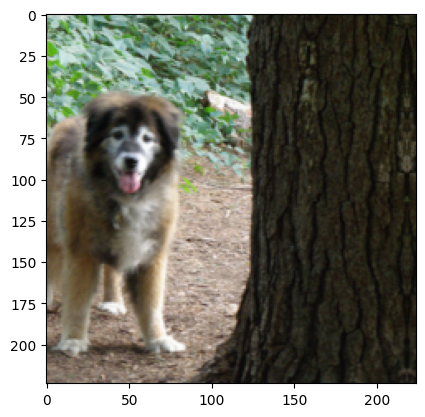

In [63]:
def show_image(image_tensor, label):
    print(f'Label : {dataset.classes[label]} ({str(label)})')
    denorm_img_tensor = denormalize(image_tensor, *imagenet_stats)[0].permute(1, 2, 0)
    plt.imshow(denorm_img_tensor)

show_image(*dataset[6000])

In [64]:
val_data_percentage = 10
val_size = int((val_data_percentage / 100) * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

print(f'Training set size : {len(train_ds)}')
print(f'Validation set size : {len(valid_ds)}')

Training set size : 6651
Validation set size : 739


In [65]:
BATCH_SIZE = 256

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(valid_ds, (BATCH_SIZE * 2), num_workers = 4, pin_memory = True)

In [66]:
def show_batch(dataloader):
    for imgs, labels in dataloader:
        fig, axs = plt.subplots(figsize = (16, 16))
        axs.set_xticks([]); axs.set_yticks([]);
        axs.imshow(make_grid(denormalize(imgs[:64], *imagenet_stats)).permute(1, 2, 0))
        break

tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])
tensor([[[[0.2990]],

         [[0.2240]],

         [[0.2250]]]])


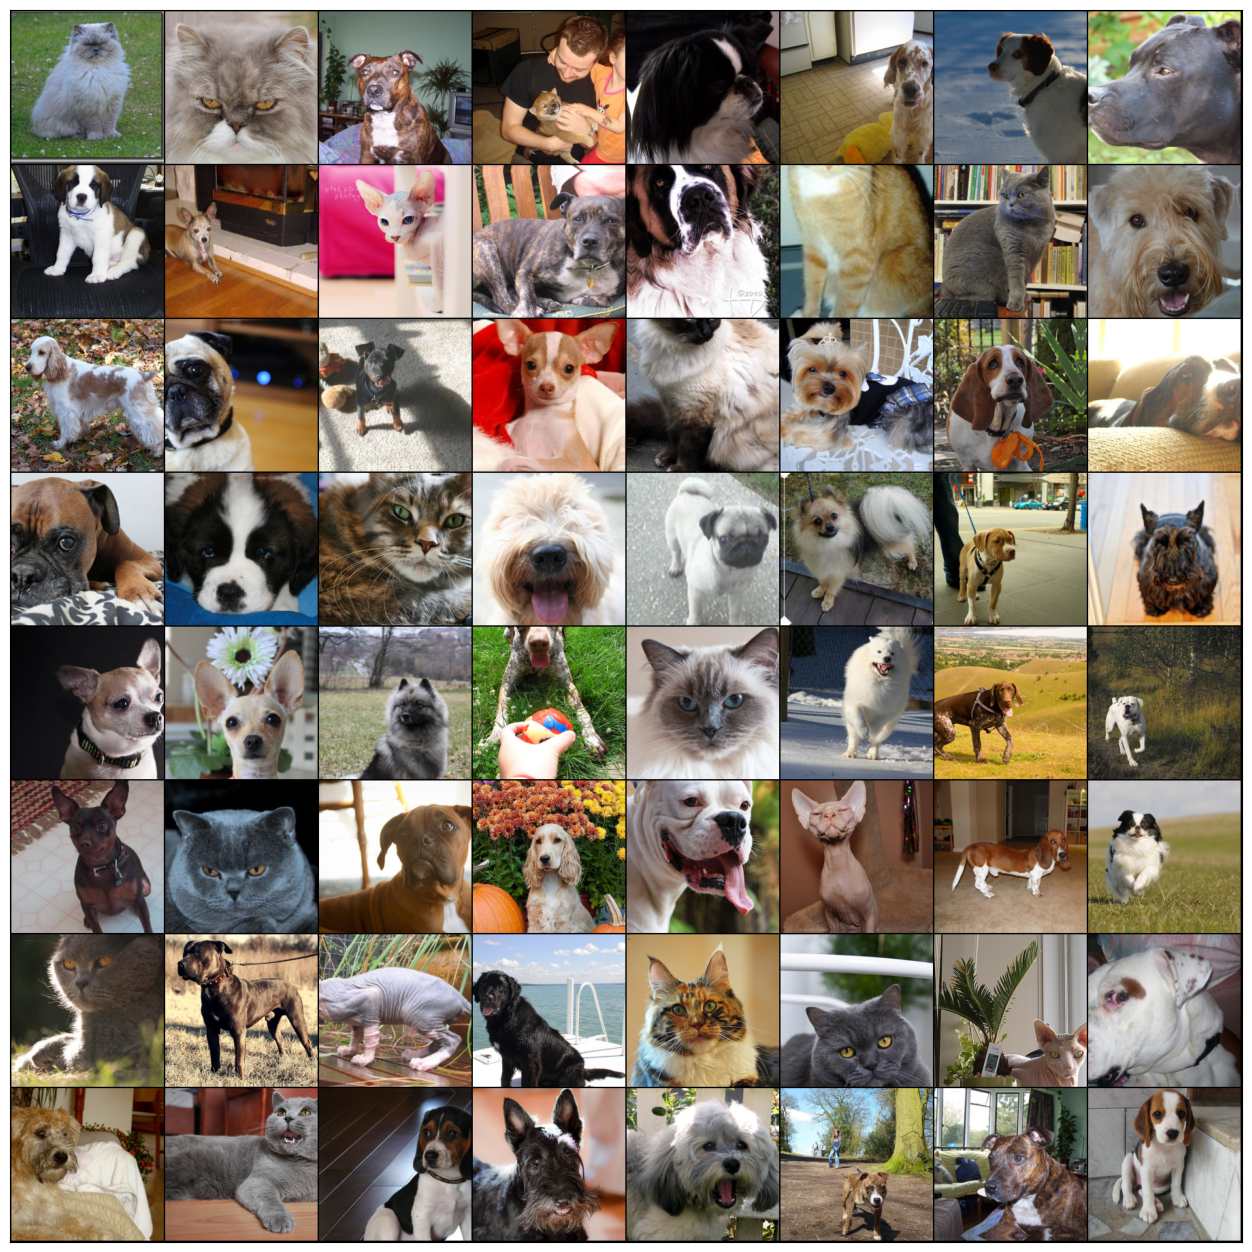

In [67]:
show_batch(train_dl)

## Modifying a pre-trained CNN for classification (ResNet34) (via Transfer Learning)

In [68]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [69]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        output = self(images)
        loss = F.cross_entropy(output, labels)
        return loss 

    def validation_step(self, batch):
        images, labels = batch 
        output = self(images)
        loss = F.cross_entropy(output, labels)
        acc = accuracy(output, labels)
        return {'val_loss' : loss.detach(), 'val_acc' : acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss' : epoch_loss.item(), 'val_acc' : epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch} : Val loss = {result['val_loss']:.4f} ; Val accuracy = {result['val_acc']:.4f}")


In [70]:
class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained = True):
        super().__init__()
        self.network = models.resnet34(pretrained = pretrained)

        # only modifying the final Linear classification layer (for getting 37 class-probabs)
        self.network.fc = nn.Linear(in_features = self.network.fc.in_features, out_features = num_classes)

    def forward(self, x):
        return self.network(x)

In [71]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [72]:
# to move batches of training data to GPU
class DeviceDataLoader(): 
    def __init__(self, loader, device):
        self.loader = loader
        self.device = device 

    def __iter__(self):
        """yield a batch of data after moving it to device"""
        for batch in self.loader:
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of training batches"""
        return len(self.loader)

In [73]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    result_batch = model.validation_epoch_end(outputs)
    return result_batch

def fit(epochs, lr, model, train_loader, val_loader, opt = torch.optim.SGD):
    history = []
    optimizer = opt(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()

        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [74]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# faster convergence, escape poor local minima
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay = 0, grad_clip = None, opt = torch.optim.SGD):
    """Dynamically adjusting Learning rate (high lr -> big steps towards minima, low lr -> gradual descent)"""
    torch.cuda.empty_cache()
    optimizer = opt(model.parameters(), max_lr, weight_decay = weight_decay)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs = epochs, 
                                                    steps_per_epoch = len(train_loader))

    history = []

    for epoch in range(epochs):
        model.train()
        train_losses = [] 
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip is not None:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            scheduler.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs

        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [75]:
DEVICE = get_default_device()
print(DEVICE)

cuda


In [76]:
train_dl = DeviceDataLoader(train_dl, DEVICE)
valid_dl = DeviceDataLoader(valid_dl, DEVICE)

In [77]:
model = PetsModel(len(dataset.classes), pretrained = True)
to_device(model, DEVICE)

PetsModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [78]:
EPOCHS = 10
max_lr = 1e-2 
grad_clip = 0.1
weight_decay = 1e-4
opt = torch.optim.Adam

In [79]:
%%time
history = fit_one_cycle(EPOCHS, max_lr, model, train_dl, valid_dl, grad_clip = grad_clip, weight_decay = weight_decay,
              opt = opt)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 : Val loss = 4.4705 ; Val accuracy = 0.1914


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 : Val loss = 4.0850 ; Val accuracy = 0.0660


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 : Val loss = 3.0429 ; Val accuracy = 0.1687


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 : Val loss = 2.4735 ; Val accuracy = 0.3378


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 : Val loss = 4.6090 ; Val accuracy = 0.2870


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 : Val loss = 1.3191 ; Val accuracy = 0.6211


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 : Val loss = 0.9238 ; Val accuracy = 0.7143


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 : Val loss = 0.6105 ; Val accuracy = 0.8150


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 : Val loss = 0.5611 ; Val accuracy = 0.8338


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 : Val loss = 0.5043 ; Val accuracy = 0.8499
CPU times: user 2min 55s, sys: 2min 26s, total: 5min 21s
Wall time: 6min 20s


In [80]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.5217900276184082, 'val_acc': 0.8457590341567993}]

In [82]:
print('Available models (pytorch provided)')
dir(models)

Available models (pytorch provided)


['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'